In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.text_cleaning_utils import TextCleaner
import os
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean white background with grid lines
sns.set_palette("deep")  # Using a clear colorful palette for better contrast
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Dataset Analysis and Cleaning Report

This notebook analyzes the original and augmented datasets for the Bangla cyberbullying detection project. It examines data quality issues like missing values, empty strings, and duplicates before and after text cleaning.

## 1. Loading Datasets

In [16]:
# Load original dataset
original_comments_df = pd.read_excel("../dataset/Original_comments_dataset.xlsx")
print("Original dataset shape:", original_comments_df.shape)

# Load augmented dataset
try:
    augmented_df = pd.read_csv(
        "../dataset/Final_augmented_balanced_dataset 58812.csv",
        engine="pyarrow",
        encoding="utf-8"
    )
    print("Augmented dataset shape:", augmented_df.shape)
except Exception as e:
    print(f"Error loading augmented dataset: {e}")
    augmented_df = None

Original dataset shape: (44001, 5)
Augmented dataset shape: (58812, 2)


## 2. Data Quality Analysis (Pre-Cleaning)

In [17]:
original_comments_df

,comment,Category,Gender,comment react number,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully
4,পটকা মাছ,Politician,Male,0.0,troll
...,...,...,...,...,...
43996,"হিরো আলম,, এগিয়ে যাও",Social,Male,0.0,not bully
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,Social,Male,1.0,not bully
43998,হিরো ভাই তুমি এগিয়ে য়াও,Social,Male,0.0,not bully
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,Actor,Female,1.0,not bully


In [18]:
def analyze_dataset_quality(df, text_column, name="Dataset"):
    """Function to analyze dataset quality in terms of missing values, empty strings and duplicates"""
    report = {
        "dataset_name": name,
        "total_records": len(df),
        "na_count": df[text_column].isna().sum(),
        "empty_count": (df[text_column] == '').sum(),
        "duplicate_count": df.duplicated(subset=[text_column]).sum(),
        "top_duplicates": df[text_column].value_counts().head(10),
    }
    
    # Print formatted report
    print(f"\n{'='*20} {name} QUALITY REPORT {'='*20}")
    print(f"Total records: {report['total_records']}")
    print(f"NA values in '{text_column}': {report['na_count']} ({report['na_count']/report['total_records']*100:.2f}%)")
    print(f"Empty strings: {report['empty_count']} ({report['empty_count']/report['total_records']*100:.2f}%)")
    print(f"Duplicate records: {report['duplicate_count']} ({report['duplicate_count']/report['total_records']*100:.2f}%)")
    
    if report['duplicate_count'] > 0:
        print(f"\nTop 10 most common duplicated texts:")
        for text, count in report['top_duplicates'].items():
            if count > 1:  # Only show duplicates
                print(f"'{text}': {count} occurrences")
                
    return report

# Analyze original dataset
original_report = analyze_dataset_quality(original_comments_df, "comment", "ORIGINAL DATASET")

# Analyze augmented dataset if available
if augmented_df is not None:
    augmented_report = analyze_dataset_quality(augmented_df, "text", "AUGMENTED DATASET")


==================== ORIGINAL DATASET QUALITY REPORT ====================
Total records: 44001
NA values in 'comment': 0 (0.00%)
Empty strings: 0 (0.00%)
Duplicate records: 434 (0.99%)

Top 10 most common duplicated texts:
'মাগি': 4 occurrences
'ধন্যবাদ': 4 occurrences
'সহমত': 4 occurrences
'নাস্তিক': 4 occurrences
'রাইট': 3 occurrences
'খানকি': 3 occurrences
'ঠেলার নাম বাবাজি': 3 occurrences
'সহমত ভাই': 3 occurrences
'আল্লাহ তো নেই। ক্ষমা করবে কী করে?আপনার নাস্তিকতা মন আগের মতই আছে৷ এটা জাস্ট ক্যারিয়ার হারানোর ভয়ে বলতেছেন৷ কারণ আপনার কাছে সৃষ্টিকর্তা বিশ্বাসের চেয়ে ক্যারিয়ার বাঁচানো টা বড় কিছু৷': 3 occurrences
'বেশ্যা': 3 occurrences

==================== AUGMENTED DATASET QUALITY REPORT ====================
Total records: 58812
NA values in 'text': 0 (0.00%)
Empty strings: 0 (0.00%)
Duplicate records: 5713 (9.71%)

Top 10 most common duplicated texts:
'atheist': 19 occurrences
'You're an atheist.': 18 occurrences
'তুমি একজন নাস্তিক।': 16 occurrences
'Show him.': 10 occurrences
'She 

## 3. Text Cleaning

In [19]:
def clean_dataset(df, text_column, name="Dataset"):
    """Clean the dataset using TextCleaner and report changes"""
    print(f"\n{'='*20} CLEANING {name} {'='*20}")
    
    # Initialize text cleaner
    text_cleaner = TextCleaner()
    
    # Create a copy for cleaning
    df_cleaned = df.copy()
    
    # Remove NA values and report
    na_count_before = df_cleaned[text_column].isna().sum()
    df_cleaned = df_cleaned.dropna(subset=[text_column])
    na_removed = na_count_before - df_cleaned[text_column].isna().sum()
    print(f"Removed {na_removed} NA values")
    
    # Apply text cleaning functions
    print("Applying text cleaning...")
    df_cleaned[text_column] = (
        df_cleaned[text_column]
        .apply(lambda x: str(x))  # Ensure all values are strings
        .apply(text_cleaner.remove_digits)
        .apply(text_cleaner.remove_english_and_special_chars)
        .apply(text_cleaner.remove_stopwords)
        .apply(text_cleaner.remove_emojis)
    )
    
    # Check for empty strings after cleaning
    empty_after = df_cleaned[df_cleaned[text_column] == ""].shape[0]
    print(f"Empty strings after cleaning: {empty_after}")
    
    # Remove empty strings
    df_cleaned = df_cleaned[df_cleaned[text_column] != ""]
    print(f"Removed {empty_after} empty strings")
    
    # Check for duplicates after cleaning
    duplicates_after = df_cleaned.duplicated(subset=[text_column]).sum()
    print(f"Duplicated texts after cleaning: {duplicates_after}")
    
    # Remove duplicates
    df_cleaned = df_cleaned.drop_duplicates(subset=[text_column])
    print(f"Removed {duplicates_after} duplicates")
    print(f"Final size of cleaned dataset: {len(df_cleaned)}")
    
    return df_cleaned

# Clean the original dataset
original_cleaned = clean_dataset(original_comments_df, "comment", "ORIGINAL DATASET")

# Clean the augmented dataset if available
if augmented_df is not None:
    augmented_cleaned = clean_dataset(augmented_df, "text", "AUGMENTED DATASET")


==================== CLEANING ORIGINAL DATASET ====================
Removed 0 NA values
Applying text cleaning...
Empty strings after cleaning: 85
Removed 85 empty strings
Duplicated texts after cleaning: 2009
Removed 2009 duplicates
Final size of cleaned dataset: 41907

==================== CLEANING AUGMENTED DATASET ====================
Removed 0 NA values
Applying text cleaning...
Empty strings after cleaning: 4154
Removed 4154 empty strings
Duplicated texts after cleaning: 6670
Removed 6670 duplicates
Final size of cleaned dataset: 47988


## 4. Post-Cleaning Analysis

In [20]:
# Analyze cleaned original dataset
original_cleaned_report = analyze_dataset_quality(original_cleaned, "comment", "CLEANED ORIGINAL DATASET")

# Analyze cleaned augmented dataset if available
if augmented_df is not None and 'augmented_cleaned' in locals():
    augmented_cleaned_report = analyze_dataset_quality(augmented_cleaned, "text", "CLEANED AUGMENTED DATASET")


==================== CLEANED ORIGINAL DATASET QUALITY REPORT ====================
Total records: 41907
NA values in 'comment': 0 (0.00%)
Empty strings: 0 (0.00%)
Duplicate records: 0 (0.00%)

==================== CLEANED AUGMENTED DATASET QUALITY REPORT ====================
Total records: 47988
NA values in 'text': 0 (0.00%)
Empty strings: 0 (0.00%)
Duplicate records: 0 (0.00%)


## 5. Class Distribution Analysis


==================== CLEANED ORIGINAL DATASET CLASS DISTRIBUTION ====================
label
not bully    14261
troll        10155
sexual        8629
religious     7212
threat        1650
Name: count, dtype: int64


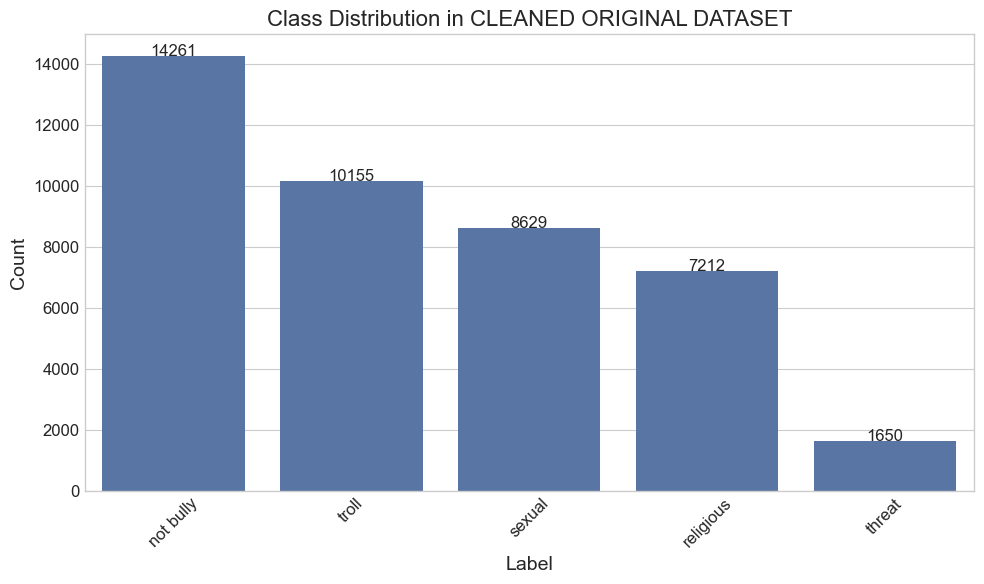

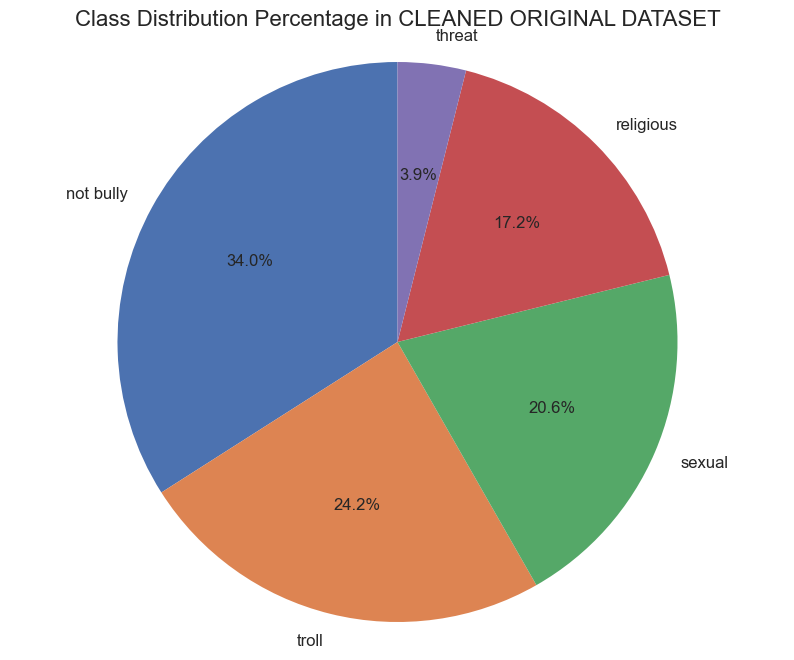


==================== CLEANED AUGMENTED DATASET CLASS DISTRIBUTION ====================
label
not bully    14261
religious    10681
troll        10155
sexual        8629
threat        4262
Name: count, dtype: int64


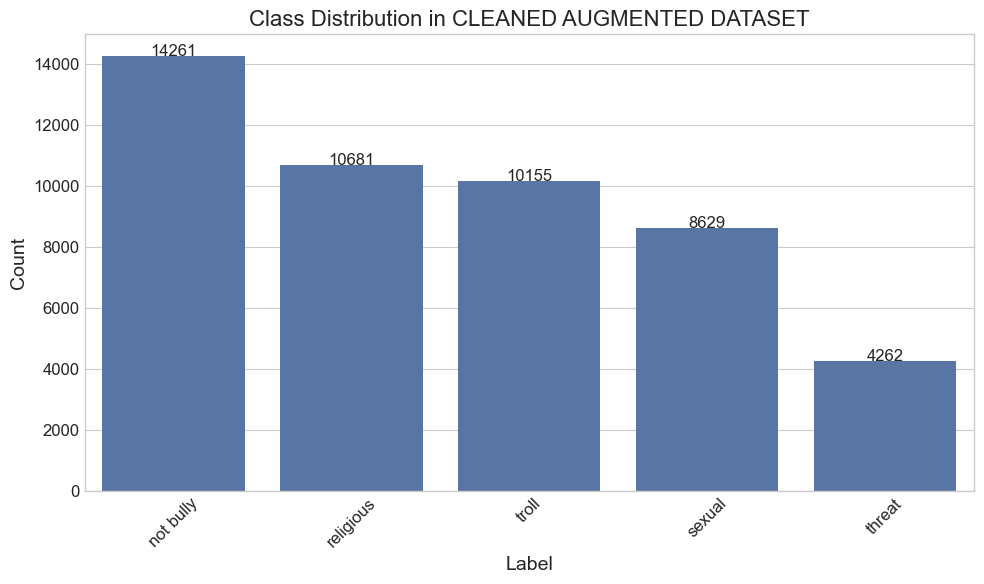

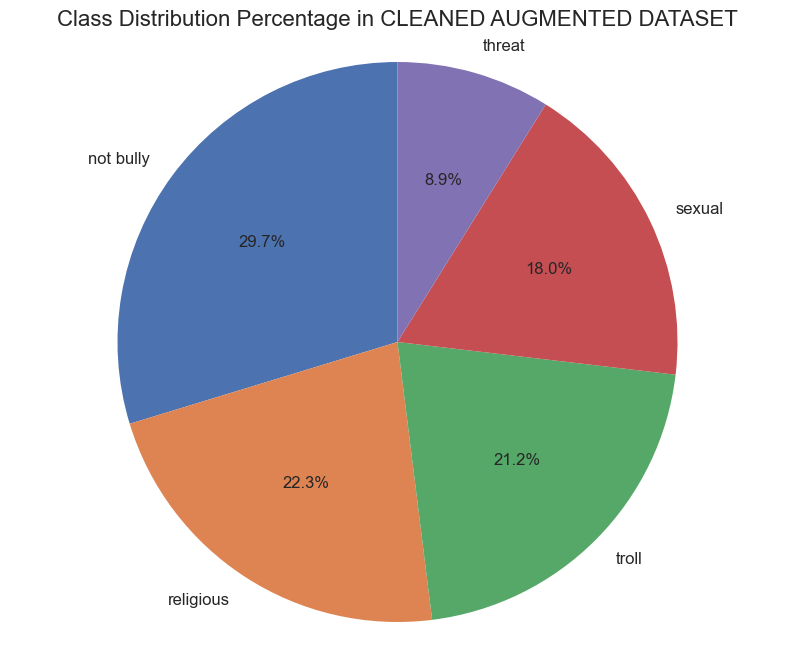

In [21]:
def analyze_class_distribution(df, label_column, name="Dataset"):
    """Analyze and visualize the class distribution in a dataset"""
    print(f"\n{'='*20} {name} CLASS DISTRIBUTION {'='*20}")
    class_counts = df[label_column].value_counts()
    print(class_counts)
    
    # Create visualization for class distribution
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title(f"Class Distribution in {name}", fontsize=16)
    plt.xlabel("Label", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45)
    
    # Add count labels on top of bars
    for i, v in enumerate(class_counts.values):
        ax.text(i, v + 0.1, str(v), ha='center', fontsize=12)
        
    plt.tight_layout()
    plt.show()
    
    # Calculate class percentages
    class_percentages = class_counts / class_counts.sum() * 100
    
    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(class_percentages, labels=class_percentages.index, autopct='%1.1f%%', 
            startangle=90, textprops={'fontsize': 12})
    plt.title(f"Class Distribution Percentage in {name}", fontsize=16)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    plt.show()
    
    return class_counts, class_percentages

# Analyze class distribution in original dataset
original_class_counts, original_percentages = analyze_class_distribution(
    original_cleaned, "label", "CLEANED ORIGINAL DATASET")

# Analyze class distribution in augmented dataset
if augmented_df is not None and 'augmented_cleaned' in locals():
    augmented_class_counts, augmented_percentages = analyze_class_distribution(
        augmented_cleaned, "label", "CLEANED AUGMENTED DATASET")

## 6. Text Length Analysis


==================== CLEANED ORIGINAL DATASET TEXT LENGTH ANALYSIS ====================
Text length statistics:
count    41907.000000
mean        72.414513
std        101.830717
min          1.000000
25%         21.000000
50%         39.000000
75%         80.000000
max       1163.000000
Name: text_length, dtype: float64


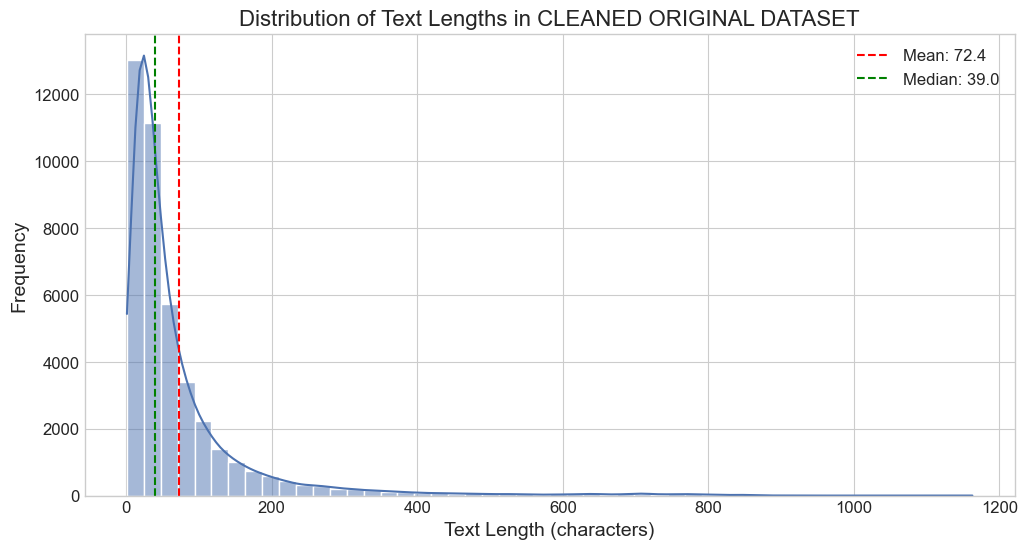

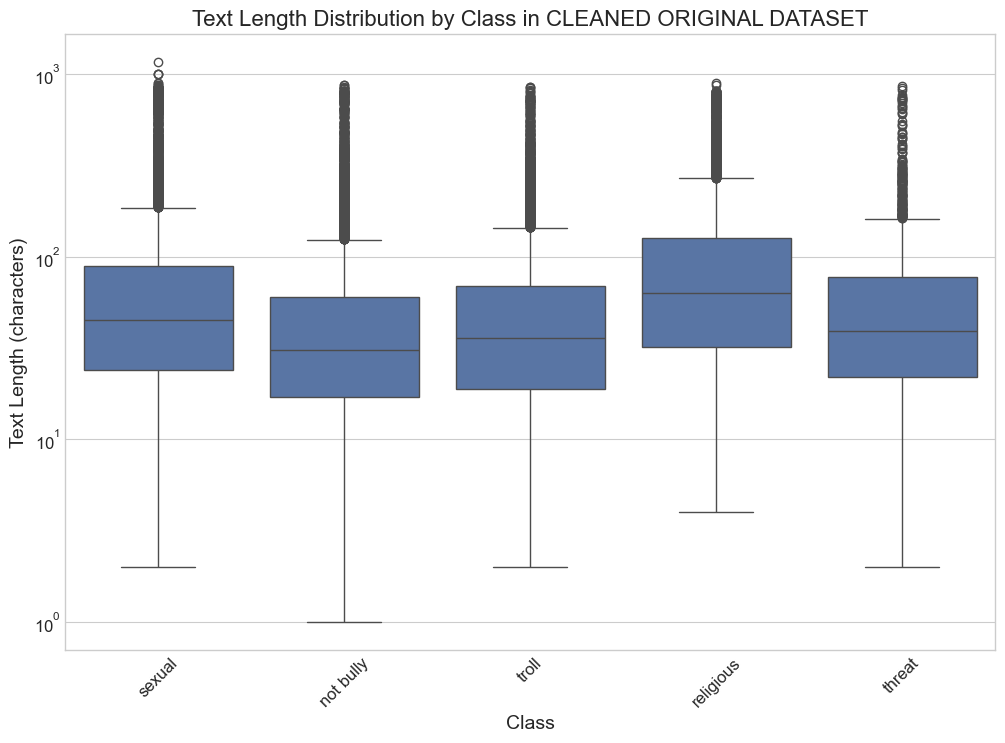

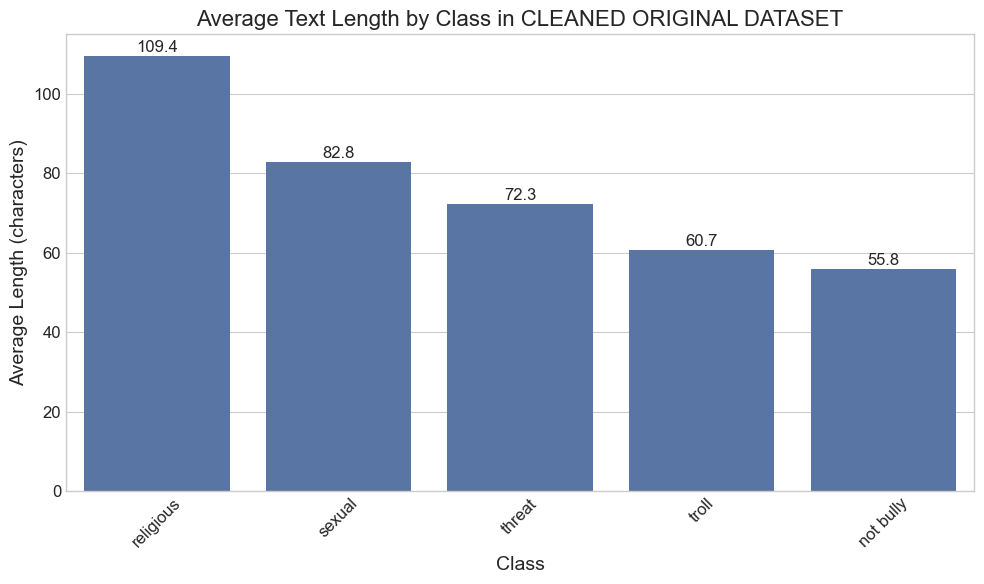


==================== CLEANED AUGMENTED DATASET TEXT LENGTH ANALYSIS ====================
Text length statistics:
count    47988.000000
mean        73.821059
std        103.951669
min          1.000000
25%         22.000000
50%         41.000000
75%         82.000000
max       2554.000000
Name: text_length, dtype: float64


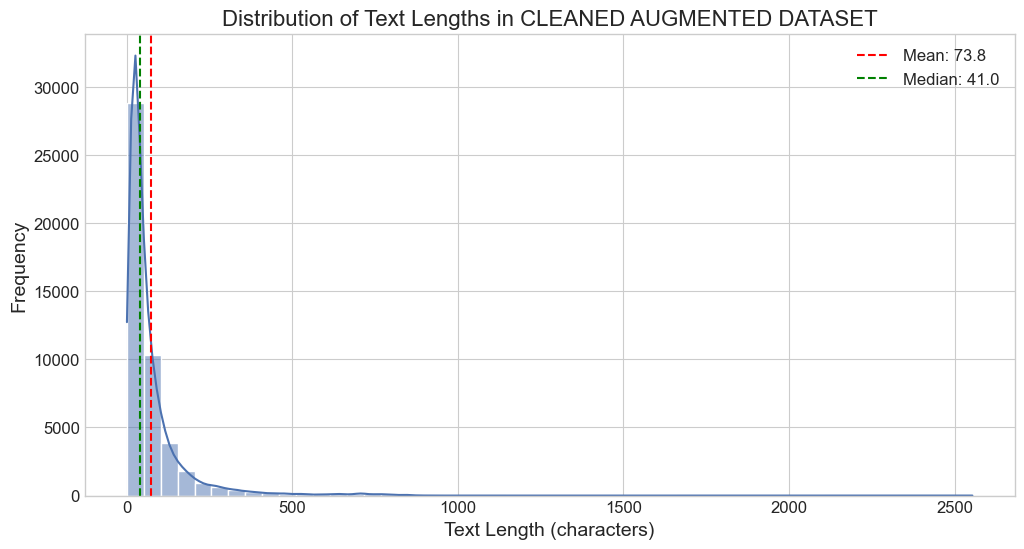

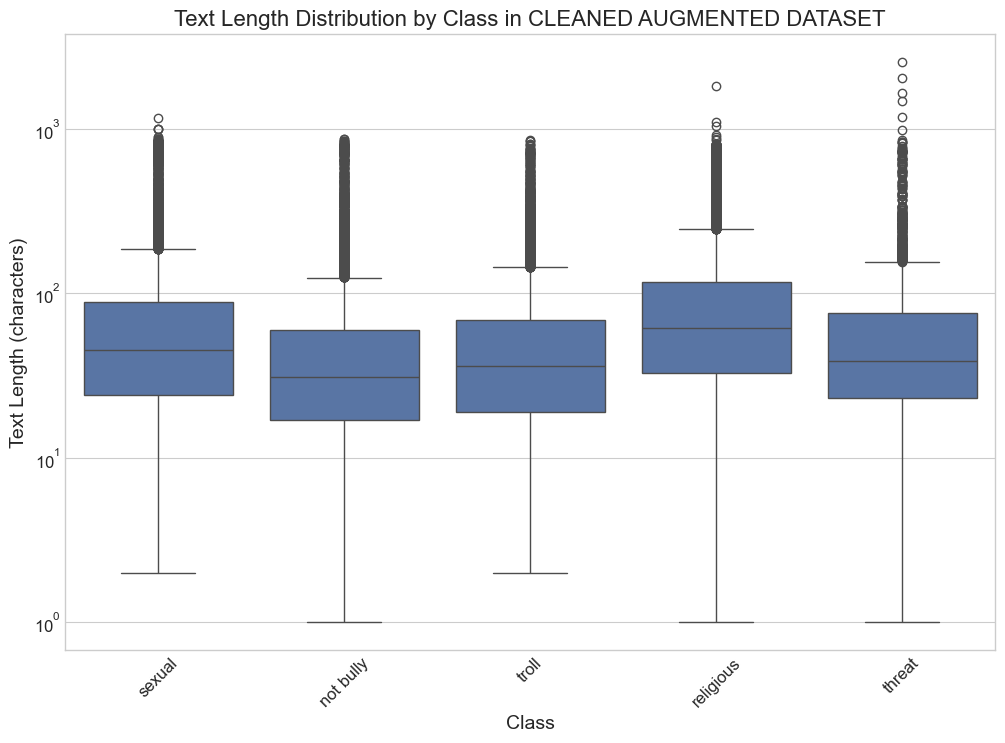

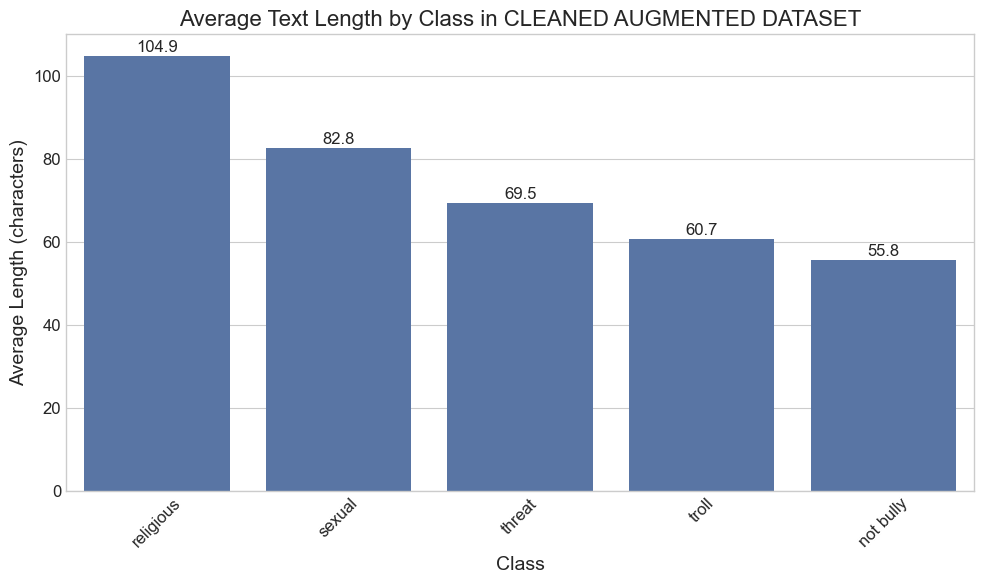

In [22]:
def analyze_text_length(df, text_column, label_column, name="Dataset"):
    """Analyze text length distribution and its relationship with classes"""
    print(f"\n{'='*20} {name} TEXT LENGTH ANALYSIS {'='*20}")

    # Calculate text lengths
    df["text_length"] = df[text_column].apply(len)

    # Show summary statistics
    length_stats = df["text_length"].describe()
    print("Text length statistics:")
    print(length_stats)

    # Create histogram of text lengths
    plt.figure(figsize=(12, 6))
    sns.histplot(df["text_length"], bins=50, kde=True)
    plt.title(f"Distribution of Text Lengths in {name}", fontsize=16)
    plt.xlabel("Text Length (characters)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.axvline(
        x=length_stats["mean"],
        color="red",
        linestyle="--",
        label=f"Mean: {length_stats['mean']:.1f}",
    )
    plt.axvline(
        x=length_stats["50%"],
        color="green",
        linestyle="--",
        label=f"Median: {length_stats['50%']:.1f}",
    )
    plt.legend()
    plt.show()

    # Distribution of text lengths by class
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=label_column, y="text_length", data=df)
    plt.title(f"Text Length Distribution by Class in {name}", fontsize=16)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Text Length (characters)", fontsize=14)
    plt.yscale("log")  # Log scale for better visualization if there are outliers
    plt.xticks(rotation=45)
    plt.show()

    # Average text length by class
    avg_length_by_class = (
        df.groupby(label_column)["text_length"].mean().sort_values(ascending=False)
    )
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_length_by_class.index, y=avg_length_by_class.values)
    plt.title(f"Average Text Length by Class in {name}", fontsize=16)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Average Length (characters)", fontsize=14)
    plt.xticks(rotation=45)

    # Add average values on top of bars
    for i, v in enumerate(avg_length_by_class):
        plt.text(i, v + 1, f"{v:.1f}", ha="center")

    plt.tight_layout()
    plt.show()

    return length_stats, avg_length_by_class


# Analyze text length in original dataset
original_length_stats, original_avg_len_by_class = analyze_text_length(
    original_cleaned, "comment", "label", "CLEANED ORIGINAL DATASET"
)

# Analyze text length in augmented dataset
if augmented_df is not None and "augmented_cleaned" in locals():
    augmented_length_stats, augmented_avg_len_by_class = analyze_text_length(
        augmented_cleaned, "text", "label", "CLEANED AUGMENTED DATASET"
    )

## 7. Creating "Only Augmented" Dataset

This dataset contains only the comments that were generated in the augmentation process and not present in the original dataset.


==== CREATING ONLY AUGMENTED DATASET ====

Size of only augmented dataset: 6081
Number of NA values: 0
Number of empty strings: 0
Number of duplicated comments: 0

==================== ONLY AUGMENTED COMMENTS CLASS DISTRIBUTION ====================
label
religious    3469
threat       2612
Name: count, dtype: int64


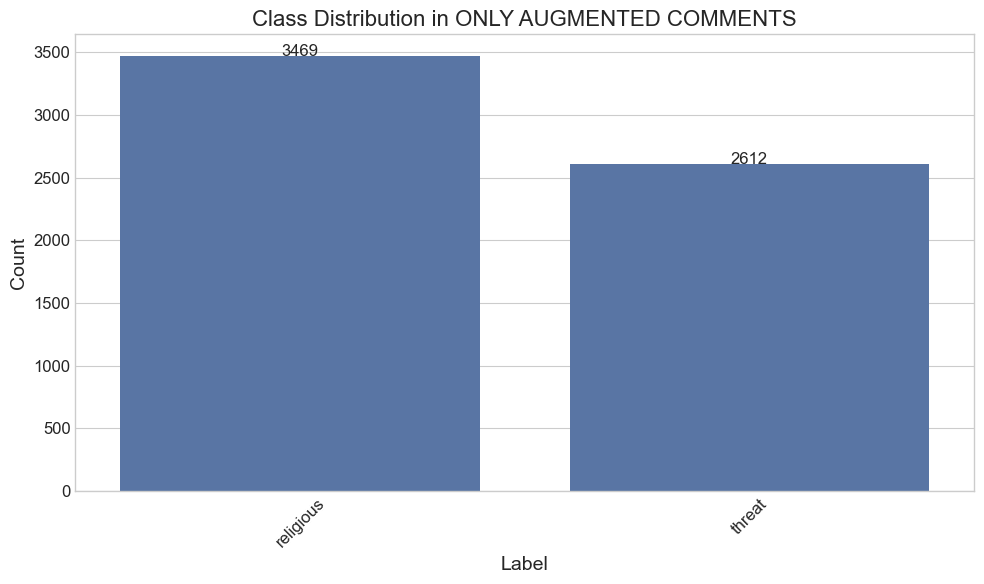

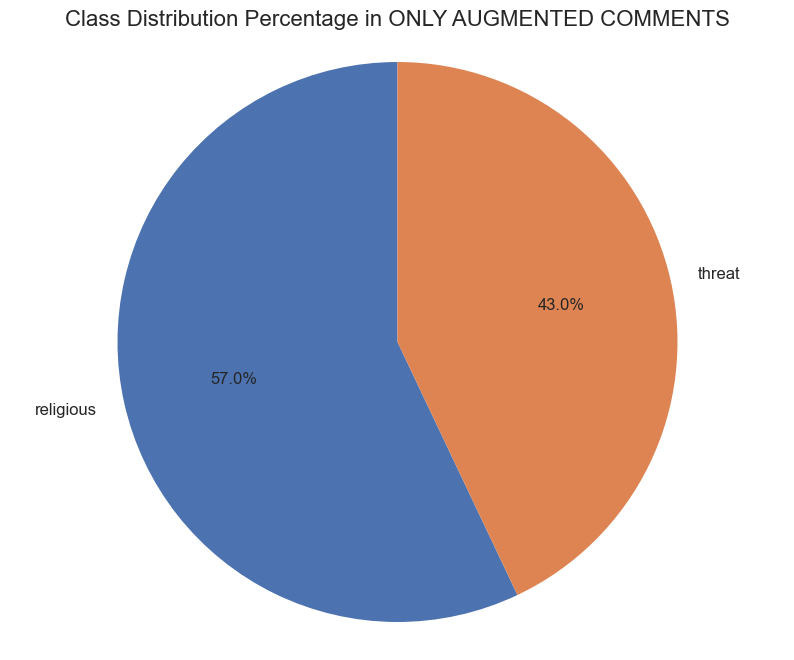

In [23]:
if augmented_df is not None and 'augmented_cleaned' in locals():
    # Create the only augmented dataset (comments that are only in the augmented dataset)
    print("\n==== CREATING ONLY AUGMENTED DATASET ====\n")
    only_augmented_comments = augmented_cleaned[
        ~augmented_cleaned["text"].isin(original_cleaned["comment"])
    ]

    # Remove any remaining duplicates
    only_augmented_comments = only_augmented_comments.drop_duplicates(subset=["text"])
    only_augmented_comments = only_augmented_comments[only_augmented_comments["text"] != ""]

    print(f"Size of only augmented dataset: {len(only_augmented_comments)}")
    print(f"Number of NA values: {only_augmented_comments['text'].isna().sum()}")
    print(f"Number of empty strings: {len(only_augmented_comments[only_augmented_comments['text'] == ''])}")
    print(f"Number of duplicated comments: {only_augmented_comments.duplicated(subset=['text']).sum()}")
    
    # Class distribution in only augmented dataset
    augmented_only_class_counts = analyze_class_distribution(
        only_augmented_comments, "label", "ONLY AUGMENTED COMMENTS")

## 8. Export Cleaned Datasets

In [24]:
# # Create output directory if it doesn't exist
# os.makedirs("../dataset/cleaned", exist_ok=True)

# # Export original cleaned dataset
# original_cleaned.to_csv(
#     "../dataset/cleaned/original_cleaned.csv", index=False, encoding="utf-8"
# )
# print("Exported cleaned original dataset")

# # Export augmented cleaned dataset
# if augmented_df is not None and "augmented_cleaned" in locals():
#     augmented_cleaned.to_csv(
#         "../dataset/cleaned/augmented_cleaned.csv", index=False, encoding="utf-8"
#     )
#     print("Exported cleaned augmented dataset")

#     # Export only augmented dataset
#     if "only_augmented_comments" in locals():
#         only_augmented_comments.to_csv(
#             "../dataset/cleaned/only_augmented.csv", index=False, encoding="utf-8"
#         )
#         print("Exported only augmented dataset")

## 9. Summary Report


=== DATASET CLEANING SUMMARY ===


,Dataset,Total Records,NA Values,Empty Strings,Duplicates,Only Augmented Records
0,Original (Before),44001,0,0,434,N/A
1,Original (After),41907,0,0,0,N/A
2,Augmented (Before),58812,0,0,5713,N/A
3,Augmented (After),47988,0,0,0,6081


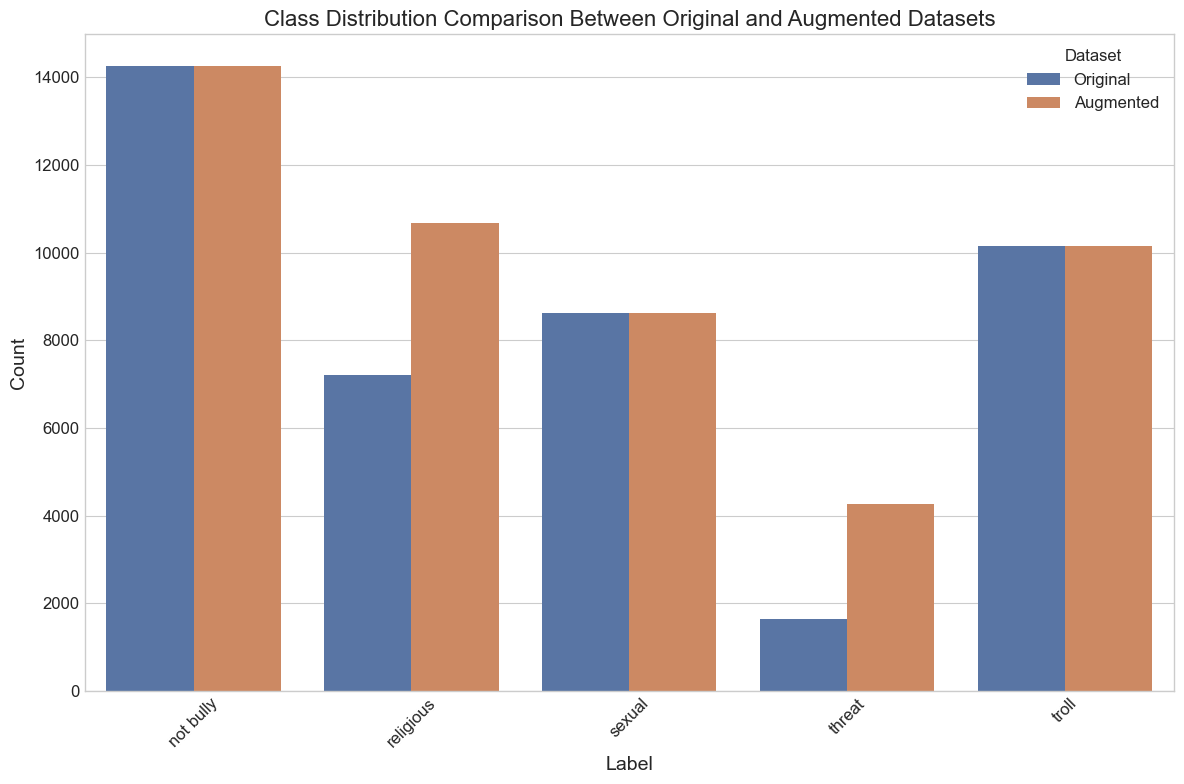


Class Balance Improvement:
not bully: 0.0% change (14261 → 14261)
religious: 48.1% change (7212 → 10681)
sexual: 0.0% change (8629 → 8629)
threat: 158.3% change (1650 → 4262)
troll: 0.0% change (10155 → 10155)


In [25]:
# Create a summary table for comparing datasets before and after cleaning
summary_data = {
    "Dataset": [
        "Original (Before)",
        "Original (After)",
        "Augmented (Before)",
        "Augmented (After)",
    ],
    "Total Records": [
        original_report["total_records"],
        len(original_cleaned),
        augmented_report["total_records"] if augmented_df is not None else "N/A",
        len(augmented_cleaned) if augmented_df is not None else "N/A",
    ],
    "NA Values": [
        original_report["na_count"],
        0,
        augmented_report["na_count"] if augmented_df is not None else "N/A",
        0,
    ],
    "Empty Strings": [
        original_report["empty_count"],
        0,
        augmented_report["empty_count"] if augmented_df is not None else "N/A",
        0,
    ],
    "Duplicates": [
        original_report["duplicate_count"],
        original_cleaned.duplicated(subset=["comment"]).sum(),
        augmented_report["duplicate_count"] if augmented_df is not None else "N/A",
        (
            augmented_cleaned.duplicated(subset=["text"]).sum()
            if augmented_df is not None
            else "N/A"
        ),
    ],
    "Only Augmented Records": [
        "N/A",
        "N/A",
        "N/A",
        (
            len(only_augmented_comments)
            if augmented_df is not None and "only_augmented_comments" in locals()
            else "N/A"
        ),
    ],
}

summary_df = pd.DataFrame(summary_data)
print("\n=== DATASET CLEANING SUMMARY ===")
display(summary_df)

# Create a visual comparison of class distributions before and after augmentation
if augmented_df is not None:
    # Prepare data
    original_dist = original_class_counts.to_dict()
    augmented_dist = augmented_class_counts.to_dict()

    # All labels
    all_labels = sorted(
        list(set(list(original_dist.keys()) + list(augmented_dist.keys())))
    )

    # Create comparison data
    comp_data = {
        "Label": all_labels,
        "Original": [original_dist.get(label, 0) for label in all_labels],
        "Augmented": [augmented_dist.get(label, 0) for label in all_labels],
    }

    comp_df = pd.DataFrame(comp_data)

    # Melt the DataFrame for easier plotting with seaborn
    comp_df_melted = comp_df.melt(
        id_vars="Label", var_name="Dataset", value_name="Count"
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(x="Label", y="Count", hue="Dataset", data=comp_df_melted)
    plt.title(
        "Class Distribution Comparison Between Original and Augmented Datasets",
        fontsize=16,
    )
    plt.xlabel("Label", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

    # Calculate and print improvement percentages
    print("\nClass Balance Improvement:")
    for label in all_labels:
        orig = original_dist.get(label, 0)
        aug = augmented_dist.get(label, 0)
        if orig > 0:
            change_pct = ((aug - orig) / orig) * 100
            print(f"{label}: {change_pct:.1f}% change ({orig} → {aug})")